In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_guess, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch.nn import Linear, Sequential, ReLU, LeakyReLU
from torch.optim import Adam

In [3]:
# run only if new data is desired
ode_dim = 3
n_time_points = 10
tspan = torch.linspace(0, n_time_points, 10)
n_graphs = 1000
n_time_series = 1
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_time_series,n_graphs,tspan)

dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,n_time_points))

loader = DataLoader(dataset_train,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_time_series,128,tspan)

dataset = []
for i in range(0,len(x_test)):
    p = param_test[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data_true(x_test[i],y_test[i],ode_dim,n_time_points))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [4]:
from torch.nn import Linear, Sequential, LeakyReLU
from torch_geometric.nn import GATConv

class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=10):
        super(GCNEncoder, self).__init__()

        self.gcn1 = GCNConv(in_channels,4*out_channels)
        self.gcn2 = GCNConv(4*out_channels,out_channels)

    def forward(self, data, edge_index):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.gcn1(x, edge_index=edge_index)
        x = torch.nn.functional.leaky_relu(x)
        x = self.gcn2(x,edge_index=edge_index)
        return torch.nn.functional.leaky_relu(x)

In [5]:
class MLPDecoder(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim=16):
        super(MLPDecoder, self).__init__()
        # Define the MLP for decoding
        self.mlp = Sequential(
            Linear(2 * embedding_dim, hidden_dim),
            LeakyReLU(),
            Linear(hidden_dim, 1)  # Output a single value (edge weight) for each pair
        )

    def forward(self, z, edge_index):
        # Extract source and target node embeddings based on edge_index
        src_nodes = z[edge_index[0]]  # Shape: (num_edges, embedding_dim)
        tgt_nodes = z[edge_index[1]]  # Shape: (num_edges, embedding_dim)

        # Concatenate source and target embeddings for each pair
        edge_features = torch.cat([src_nodes, tgt_nodes], dim=-1)  # Shape: (num_nodes, num_nodes, 2 * embedding_dim)

        # Pass through MLP to predict edge weights
        edge_weights = self.mlp(edge_features).squeeze(-1)  # Shape: (num_nodes, num_nodes)

        return edge_weights

In [7]:
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_dense_adj

model = GAE(GCNEncoder(n_time_points,30),MLPDecoder(30))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = torch.nn.MSELoss()

train_loss = []

for epoch in range(3000):
    model.train()

    tr_loss = 0
    full_loss = 0
    for data in loader:
        data = data.to(device)
        batch_size = data.batch.max().item()+1
        optimizer.zero_grad()

        z = model.encode(data, data.edge_index)

        recon_part = model.decode(z,data.edge_index)

        loss = criterion(recon_part,data.edge_attr.flatten())

        train_loss.append(loss)
        full_loss += loss

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

        with torch.no_grad():
            latent_embeddings = z.cpu().detach().numpy()
    #train_loss.append(full_loss)
    print(full_loss.item())

for data in dataset_train:
    z = model.encode(data.to(device), data.edge_index)

    recon = model.decode(z,data.edge_index)

    print(recon)

91.99151611328125
93.1070556640625
91.98234558105469
90.20952606201172
90.2597427368164
90.13943481445312
90.01820373535156
90.47683715820312
89.39775848388672
88.47093200683594
88.14007568359375
87.9734878540039
88.36172485351562
87.56973266601562
88.67863464355469
89.08773803710938
88.15470886230469
87.6652603149414
87.33023071289062
87.2297592163086
87.33419036865234
86.54679870605469
88.03392791748047
87.13988494873047
87.13552856445312
87.23414611816406
86.15274810791016
86.63017272949219
87.16259002685547
86.50047302246094
86.36138153076172
86.3331298828125
86.42079162597656
86.2542495727539
87.22706604003906
86.30500793457031
86.12223815917969
86.49574279785156
85.89065551757812
86.78730773925781
88.26829528808594
86.44602966308594
85.43585968017578
85.97049713134766
85.76441192626953
86.67411041259766
85.49632263183594
86.63111877441406
85.5434799194336
85.67133331298828
85.5002212524414
85.47864532470703
85.68058776855469
86.24991607666016
85.80626678466797
85.35234069824219
8

KeyboardInterrupt: 

(3000, 30)


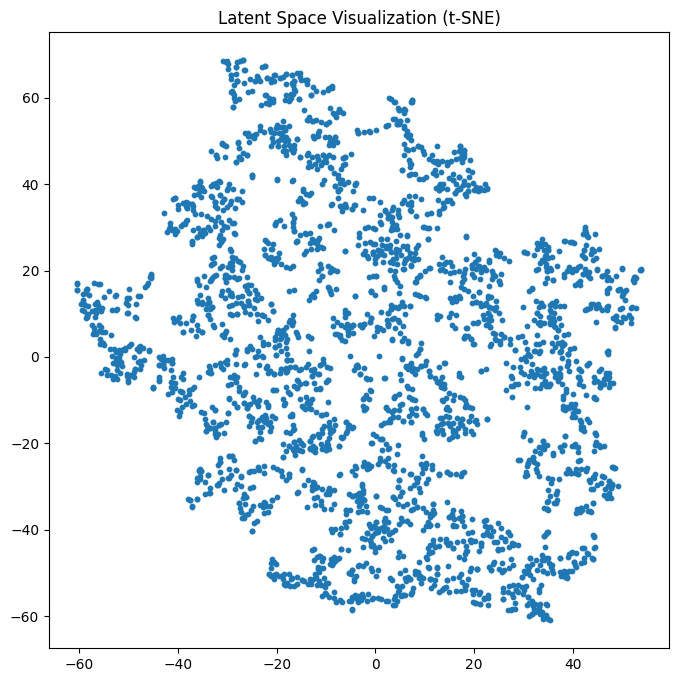

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_embeddings =  torch.tensor(1)

for data in loader:
        data = data.to(device)
        z = model.encode(data, data.edge_index)

        with torch.no_grad():
            if len(latent_embeddings.shape) == 0:
                 latent_embeddings = z
            else:
                latent_embeddings = torch.cat((latent_embeddings,z))

latent_embeddings = latent_embeddings.cpu().detach().numpy()
print(latent_embeddings.shape)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Latent Space Visualization (t-SNE)")
plt.show()

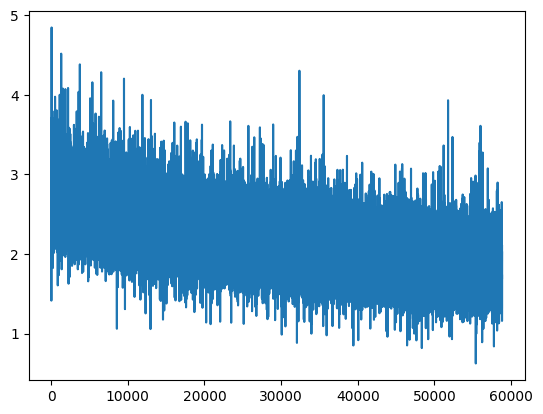

In [ ]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()

In [12]:
def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_time_series,100,tspan)

val_dataset = []
param_list = []

for i in range(0,len(x_val)):
    p = param_val[i]
    param_vec = torch.cat((p.Win.flatten(), p.Wout.flatten(), p.bin, p.bout, p.gamma)).numpy()
    param_list.append(param_vec)
    val_dataset.append(to_pyg_data_true(x_val[i],y_val[i],ode_dim,n_time_points))

val_loader = DataLoader(val_dataset,batch_size=1)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

changed = 0
fixed = 0
destroyed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    batch = batch.to(device)
    z = model.encode(batch, batch.edge_index)
    
    recon = model.decode(z,batch.edge_index)
    Ahat = recon.flatten()

    print(batch.edge_attr)
    print(Ahat)

    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.edge_attr)
    Ahat = get_adjacency(Ahat)
    print(Ahat)
    print(A)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1

    for i in range(0,len(A)):

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1   
            
        elems_total += 1

print(correct/total)
print(elem_wise/elems_total)

tensor([-4.1269,  2.1642, -2.8054,  2.0690], device='cuda:0')
tensor([ 0.2043,  2.0975,  0.5971, -2.1795], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0.,  1.,  0., -1.], device='cuda:0', dtype=torch.float64)
tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([1.8108, 1.3106, 0.3246, 0.6924], device='cuda:0')
tensor([-0.3391, -0.2600,  0.1437,  0.0300], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-1., -1.,  1.,  0.], device='cuda:0', dtype=torch.float64)
tensor([1., 1., 0., 1.], device='cuda:0', dtype=torch.float64)
tensor([-1.0242,  1.4555, -1.4150], device='cuda:0')
tensor([ 2.0292,  0.8818, -4.1759], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 1.,  0., -1.], device='cuda:0', dtype=torch.float64)
tensor([ 0.,  1., -1.], device='cuda:0', dtype=torch.float64)
tensor([-1.5295,  1.2055,  3.8614,  1.0466, -0.8904], device='cuda:0')
tensor([-2.8853, -0.7850,  3.2443, -1.9285, -1.2792], device='cuda:0',
       grad_fn=<Squ